In [1]:
using Printf
using Random
Random.seed!(4649373)

using Distributions
using StatsPlots
default(fmt=:png, titlefontsize=10, size=(500, 350))

ECDF(A, x) = count(≤(x), A) / length(A)

ECDF (generic function with 1 method)

se = √(var(distx) / m + var(disty) / n) = 0.570087712549569
se_shuffle = √(var(disty) / m + var(distx) / n) = 0.31622776601683794
  8.155939 seconds (156.61 M allocations: 4.150 GiB, 7.33% gc time, 57.14% compilation time)
mean(diff) = 0.015361067435398088
std(diff) = 0.5831801016778241
ECDF.((pval, pval2, pval3), 0.1) = (0.3645, 0.36525, 0.107)
ECDF.((pval, pval2, pval3), 0.05) = (0.29175, 0.296, 0.05225)


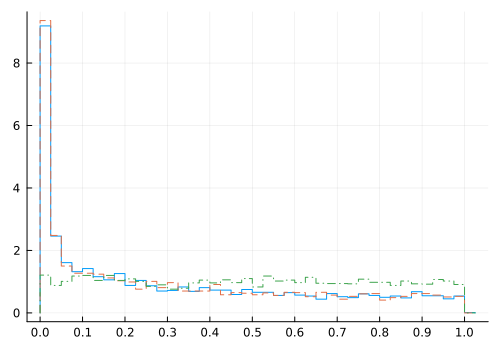

In [2]:
distx = Normal(0, 1)
m = 200
disty = Normal(0, 4)
n = 50
L = 4000
Nshuffles = 4000

@show se = √(var(distx)/m + var(disty)/n)
@show se_shuffle = √(var(disty)/m + var(distx)/n)

nth = Threads.nthreads()
XYtmp = [zeros(m+n) for _ in 1:nth]

pval = zeros(L)
pval2 = zeros(L)
pval3 = zeros(L)
diff = zeros(L)
@time Threads.@threads for i in eachindex(pval)
    tid = Threads.threadid()
    XY = XYtmp[tid]
    X = rand!(distx, @view XY[1:m])
    Y = rand!(disty, @view XY[m+1:m+n])
    diff[i] = mean(X) - mean(Y)
    diff_shuffle = zeros(Nshuffles)
    for j in 1:Nshuffles
        shuffle!(XY)
        diff_shuffle[j] = @views mean(XY[1:m]) - mean(XY[m+1:m+n])
    end
    P = 2ECDF(diff_shuffle, diff[i])
    pval[i] = min(1, P, 2-P)
    P2 = 2cdf(Normal(0, se_shuffle), diff[i])
    pval2[i] = min(1, P2, 2-P2)
    P3 = 2cdf(Normal(0, se), diff[i])
    pval3[i] = min(1, P3, 2-P3)
end

@show mean(diff) std(diff)

@show ECDF.((pval, pval2, pval3), 0.10)
@show ECDF.((pval, pval2, pval3), 0.05)
plot()
stephist!(pval; norm=true, label="", bin=0:0.025:1.025)
stephist!(pval2; norm=true, label="", bin=0:0.025:1.025, ls=:dash)
stephist!(pval3; norm=true, label="", bin=0:0.025:1.025, ls=:dashdot)
plot!(xtick=0:0.1:1)

diff = mean(X) - mean(Y) = 0.09902460533455348
se2_true = var(distx) / m + var(disty) / n = 0.325
se2_shuffle = var(distx) / n + var(disty) / m = 0.1
(mean(diff_shuffle), var(diff_shuffle)) = (0.0023808879961961025, 0.10918481570758713)


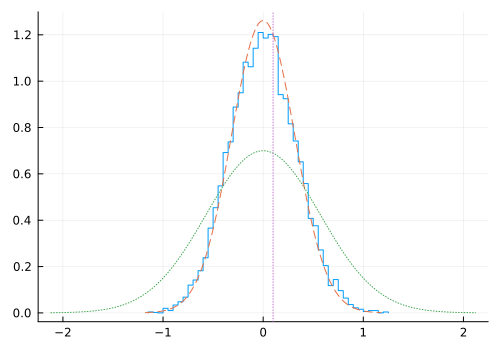

In [3]:
distx, m = Normal(0, 1), 200
disty, n = Normal(0, 4), 50
X = rand(distx, m)
Y = rand(disty, n)
@show diff = mean(X) - mean(Y)
XY = [X; Y]
Nshuffles = 10^4
diff_shuffle = zeros(Nshuffles)
for j in 1:Nshuffles
    shuffle!(XY)
    diff_shuffle[j] = @views mean(XY[1:m]) - mean(XY[m+1:m+n])
end
@show se2_true = var(distx)/m + var(disty)/n
@show se2_shuffle = var(distx)/n + var(disty)/m
@show mean(diff_shuffle), var(diff_shuffle)
stephist(diff_shuffle; norm=true, label="")
plot!(Normal(0, √se2_shuffle); label="", ls=:dash)
plot!(Normal(0, √se2_true); label="", ls=:dot)
vline!([diff]; label="", ls=:dot)

In [4]:
function welch_t_test(X, Y; μ = 0.0)
    m, X̄, SX2 = length(X), mean(X), var(X)
    n, Ȳ, SY2 = length(Y), mean(Y), var(Y)
    sehat2 = SX2/m + SY2/n
    tvalue = (X̄ - Ȳ - μ) / √sehat2
    df = sehat2^2 / ((SX2/m)^2/(m-1) + (SY2/n)^2/(n-1))
    pvalue = 2ccdf(TDist(df), abs(tvalue))
    (; pvalue, tvalue, sehat2, df)
end

pvalue_welch_t_test(X, Y; μ = 0.0) =welch_t_test(X, Y; μ).pvalue

using HypothesisTests
X = randn(100)
Y = randn(100)
pvalue_welch_t_test(X, Y), pvalue(UnequalVarianceTTest(X, Y))

(0.01799850645039118, 0.01799850645039118)

In [5]:
function student_t_test(X, Y; μ = 0.0)
    m, X̄, SX2 = length(X), mean(X), var(X)
    n, Ȳ, SY2 = length(Y), mean(Y), var(Y)
    S2 = ((m-1)*SX2 + (n-1)*SY2) / (m+n-2)
    sehat2 = S2 * (1/m + 1/n)
    tvalue = (X̄ - Ȳ - μ) / √sehat2
    df = m + n - 2
    pvalue = 2ccdf(TDist(df), abs(tvalue))
    (; pvalue, tvalue, sehat2, df)
end

pvalue_student_t_test(X, Y; μ = 0.0) = student_t_test(X, Y; μ).pvalue

using HypothesisTests
X = randn(100)
Y = randn(100)
pvalue_student_t_test(X, Y), pvalue(EqualVarianceTTest(X, Y))

(0.3847930361053551, 0.3847930361053551)

In [6]:
"""
inversegammadist(σ, β)

returns the inverse gamma distribution with standard deviation `σ` and skewness `β`.
"""
function inversegammadist(σ, β)
    β == 0 && return Normal(0, σ)
    α = 3 + 8/β^2 + 4/β * √(1 + 4/β^2)
    θ = σ * (α - 1) * √(α - 2)
    InverseGamma(α, θ)
end

igam = inversegammadist.(1:5, 2:2:10)
[std.(igam), skewness.(igam), kurtosis.(igam), shape.(igam)]

4-element Vector{Vector{Float64}}:
 [0.9999999999999999, 2.0, 3.0, 3.9999999999999996, 5.0]
 [2.0, 4.0, 6.0, 7.999999999999998, 10.0]
 [9.134446499564898, 72.54101966249682, NaN, NaN, NaN]
 [7.82842712474619, 4.618033988749895, 3.9249505911485287, 3.6403882032022077, 3.487921561087423]

In [7]:
function plot_sim_diff_shuffle(;
        distx = Normal(0, 1), m = 200,
        disty = Normal(0, 4), n = 50,
        difffunc1 = (X, Y) -> mean(X) - mean(Y),
        name1 = "perm(Δmean)",
        difffunc2 = (X, Y) -> (mean(X) - mean(Y)) / √(var(X)/length(X) + var(Y)/length(Y)),
        name2 = "perm(T-stat)",
        L = 5000,
        Nshuffles = 5000,
        α = 0.05,
    )

    @show distx disty m n
#     @show se_true = √(var(distx)/m + var(disty)/n)
#     @show se_shuffle = √(var(distx)/n + var(disty)/m)
    println()

    nth = Threads.nthreads()
    XYtmp = [zeros(m+n) for _ in 1:nth]
    diffshuffle1tmp = [zeros(Nshuffles) for _ in 1:nth]
    diffshuffle2tmp = [zeros(Nshuffles) for _ in 1:nth]

    diff1 = zeros(L)
    diff2 = zeros(L)
    pval1 = zeros(L)
    pval2 = zeros(L)
    pval_welch = zeros(L)
    pval_student = zeros(L)
    Threads.@threads for i in 1:L
        tid = Threads.threadid()
        XY = XYtmp[tid]
        diffshuffle1 = diffshuffle1tmp[tid]
        diffshuffle2 = diffshuffle2tmp[tid]
        X = rand!(distx, @view XY[1:m])
        Y = rand!(disty, @view XY[m+1:m+n])
        diff1[i] = difffunc1(X, Y)
        diff2[i] = difffunc2(X, Y)
        pval_welch[i] = pvalue_welch_t_test(X, Y)
        pval_student[i] = pvalue_student_t_test(X, Y)
        for j in 1:Nshuffles
            shuffle!(XY)
            @views X, Y = XY[1:m], XY[m+1:m+n]
            diffshuffle1[j] = difffunc1(X, Y)
            diffshuffle2[j] = difffunc2(X, Y)
        end
        P1 = 2ECDF(diffshuffle1, diff1[i])
        pval1[i] = min(1, P1, 2-P1)
        P2 = 2ECDF(diffshuffle2, diff2[i])
        pval2[i] = min(1, P2, 2-P2)
    end

#     @show mean(diff1) std(diff1)
#     @show mean(diff2) std(diff2)
#     println()
    
    er1 = ECDF(pval1, α)
    er2 = ECDF(pval2, α)
    er_student = ECDF(pval_student, α)
    er_welch = ECDF(pval_welch, α)
    @printf "Probabilities of P-valune ≤ %3.1f%%\n" 100α
    @printf "  %-15s %4.1f%%\n" name1*":" 100er1
    @printf "  %-15s %4.1f%%\n" "Student:" 100er_student
    @printf "  %-15s %4.1f%%\n" name2*":" 100er2
    @printf "  %-15s %4.1f%%\n" "Welch:" 100er_welch
    println()
    
#     αs = range(0, 1, 1001)
#     xtick = ytick = 0:0.1:1
#     P = plot()
#     plot!(αs, α -> ECDF(pval1, α), label="1", bin=0:0.025:1.025)
#     plot!(αs, α -> ECDF(pval_student, α), label="Student", bin=0:0.025:1.025, ls=:dash)
#     plot!(αs, α -> ECDF(pval2, α), label="2", bin=0:0.025:1.025, ls=:dashdot)
#     plot!(αs, α -> ECDF(pval_welch, α), label="Welch", bin=0:0.025:1.025, ls=:dashdotdot)
#     plot!(αs, identity; label="", ls=:dot, c=:black, alpha=0.7)
#     plot!(; xtick, ytick)
#     plot!(; xguide="α", yguide="probablity of P-value ≤ α")
#     plot!(; size=(400, 400))
    
    αs = range(0, 0.1, 1001)
    xtick = ytick = 0:0.01:1
    Q = plot()
    plot!(αs, α -> ECDF(pval1, α), label=name1, bin=0:0.025:1.025)
    plot!(αs, α -> ECDF(pval_student, α), label="Student", bin=0:0.025:1.025, ls=:dash)
    plot!(αs, α -> ECDF(pval2, α), label=name2, bin=0:0.025:1.025, ls=:dashdot)
    plot!(αs, α -> ECDF(pval_welch, α), label="Welch", bin=0:0.025:1.025, ls=:dashdotdot)
    plot!(αs, identity; label="", ls=:dot, c=:black, alpha=0.7)
    plot!(; xtick, ytick)
    plot!(; xguide="α", yguide="probablity of P-value ≤ α")
    plot!(; size=(400, 400))
    
#    plot(P, Q; size=(400, 400))
end

plot_sim_diff_shuffle (generic function with 1 method)

distx = Normal{Float64}(μ=0.0, σ=2.0)
disty = Normal{Float64}(μ=0.0, σ=1.0)
m = 50
n = 50

Probabilities of P-valune ≤ 5.0%
  perm(Δmean):     5.3%
  Student:         5.4%
  perm(T-stat):    5.3%
  Welch:           5.3%

  5.812174 seconds (1.39 M allocations: 95.562 MiB, 0.19% gc time, 50.52% compilation time: <1% of which was recompilation)


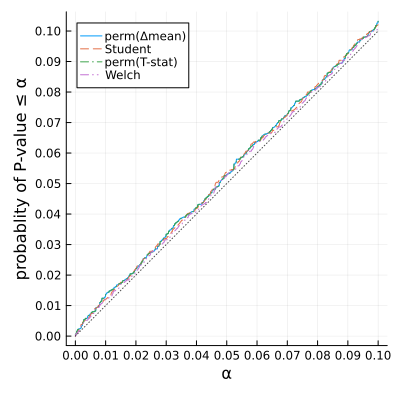

In [8]:
distx, disty = Normal(0, 2), Normal(0, 1)
m, n = 50, 50
L = Nshuffles = 5000
@time plot_sim_diff_shuffle(; distx, m, disty, n, L, Nshuffles)

distx = Normal{Float64}(μ=0.0, σ=2.0)
disty = Normal{Float64}(μ=0.0, σ=1.0)
m = 25
n = 100

Probabilities of P-valune ≤ 5.0%
  perm(Δmean):    16.5%
  Student:        17.2%
  perm(T-stat):    6.1%
  Welch:           4.6%

  5.840998 seconds (10.38 k allocations: 3.728 MiB)


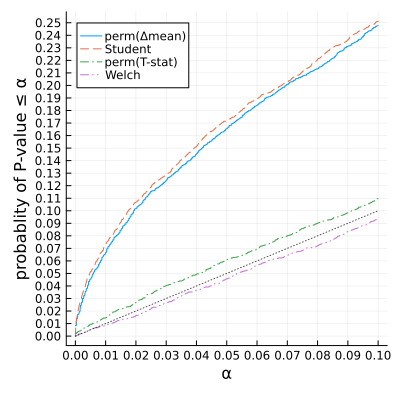

In [9]:
distx, disty = Normal(0, 2), Normal(0, 1)
m, n = 25, 100
L = Nshuffles = 5000
@time plot_sim_diff_shuffle(; distx, m, disty, n, L, Nshuffles)

distx = Normal{Float64}(μ=0.0, σ=2.0)
disty = Normal{Float64}(μ=0.0, σ=1.0)
m = 100
n = 25

Probabilities of P-valune ≤ 5.0%
  perm(Δmean):     0.6%
  Student:         0.6%
  perm(T-stat):    4.3%
  Welch:           4.9%

  5.717068 seconds (7.12 k allocations: 2.782 MiB)


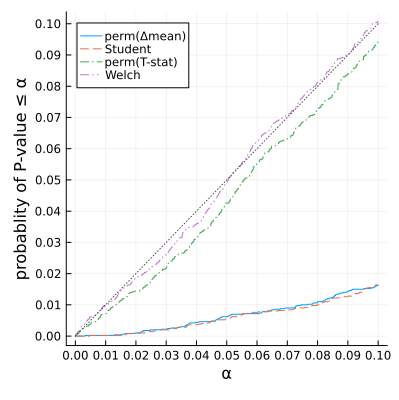

In [10]:
distx, disty = Normal(0, 2), Normal(0, 1)
m, n = 100, 25
L = Nshuffles = 5000
@time plot_sim_diff_shuffle(; distx, m, disty, n, L, Nshuffles)

distx = InverseGamma{Float64}(
invd: Gamma{Float64}(α=5.4913561224284395, θ=0.1191586113190746)
θ: 8.392175680213912
)

disty = InverseGamma{Float64}(
invd: Gamma{Float64}(α=5.4913561224284395, θ=0.1191586113190746)
θ: 8.392175680213912
)

m = 50
n = 50

Probabilities of P-valune ≤ 5.0%
  perm(Δmean):     5.3%
  Student:         4.9%
  perm(T-stat):    5.3%
  Welch:           4.9%

  5.365329 seconds (618.64 k allocations: 43.512 MiB, 44.47% compilation time)


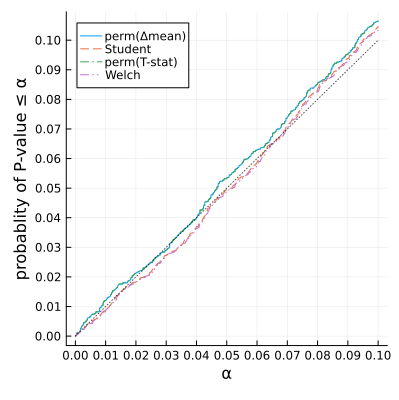

In [11]:
distx, disty = inversegammadist(1, 3), inversegammadist(1, 3)
m, n = 50, 50
L = Nshuffles = 5000
@time plot_sim_diff_shuffle(; distx, m, disty, n, L, Nshuffles)

distx = InverseGamma{Float64}(
invd: Gamma{Float64}(α=5.4913561224284395, θ=0.1191586113190746)
θ: 8.392175680213912
)

disty = InverseGamma{Float64}(
invd: Gamma{Float64}(α=5.4913561224284395, θ=0.1191586113190746)
θ: 8.392175680213912
)

m = 25
n = 100

Probabilities of P-valune ≤ 5.0%
  perm(Δmean):     5.1%
  Student:         5.0%
  perm(T-stat):    5.2%
  Welch:           6.4%

  5.859485 seconds (9.02 k allocations: 3.330 MiB, 0.23% gc time)


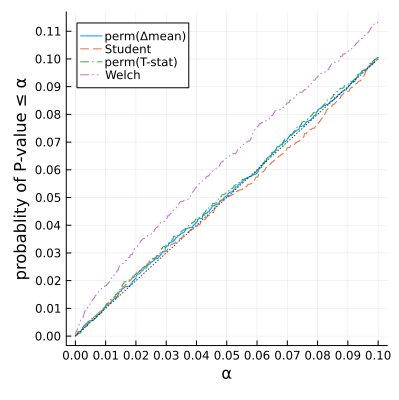

In [12]:
distx, disty = inversegammadist(1, 3), inversegammadist(1, 3)
m, n = 25, 100
L = Nshuffles = 5000
@time plot_sim_diff_shuffle(; distx, m, disty, n, L, Nshuffles)

distx = InverseGamma{Float64}(
invd: Gamma{Float64}(α=5.4913561224284395, θ=0.1191586113190746)
θ: 8.392175680213912
)

disty = InverseGamma{Float64}(
invd: Gamma{Float64}(α=5.4913561224284395, θ=0.1191586113190746)
θ: 8.392175680213912
)

m = 100
n = 400

Probabilities of P-valune ≤ 5.0%
  perm(Δmean):     5.2%
  Student:         5.2%
  perm(T-stat):    5.1%
  Welch:           5.6%

 20.587204 seconds (8.92 k allocations: 3.335 MiB)


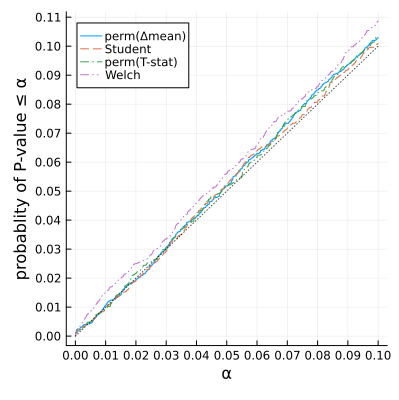

In [13]:
distx, disty = inversegammadist(1, 3), inversegammadist(1, 3)
m, n = 100, 400
L = Nshuffles = 5000
@time plot_sim_diff_shuffle(; distx, m, disty, n, L, Nshuffles)

distx = LocationScale{Float64, Continuous, InverseGamma{Float64}}(
μ: -1.8685170918213296
σ: 1.0
ρ: InverseGamma{Float64}(
invd: Gamma{Float64}(α=5.4913561224284395, θ=0.0595793056595373)
θ: 16.784351360427824
)

)

disty = InverseGamma{Float64}(
invd: Gamma{Float64}(α=5.4913561224284395, θ=0.1191586113190746)
θ: 8.392175680213912
)

m = 50
n = 50

Probabilities of P-valune ≤ 5.0%
  perm(Δmean):     6.4%
  Student:         6.3%
  perm(T-stat):    6.4%
  Welch:           6.2%

  5.158004 seconds (446.77 k allocations: 32.237 MiB, 0.20% gc time, 32.11% compilation time)


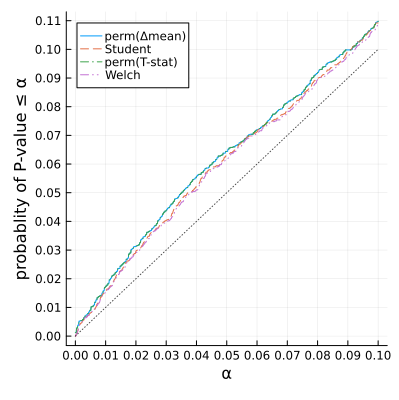

In [14]:
distx, disty = inversegammadist(2, 3), inversegammadist(1, 3)
distx = distx + mean(disty) - mean(distx)
m, n = 50, 50
L = Nshuffles = 5000
@time plot_sim_diff_shuffle(; distx, m, disty, n, L, Nshuffles)

distx = LocationScale{Float64, Continuous, InverseGamma{Float64}}(
μ: -1.8685170918213296
σ: 1.0
ρ: InverseGamma{Float64}(
invd: Gamma{Float64}(α=5.4913561224284395, θ=0.0595793056595373)
θ: 16.784351360427824
)

)

disty = InverseGamma{Float64}(
invd: Gamma{Float64}(α=5.4913561224284395, θ=0.1191586113190746)
θ: 8.392175680213912
)

m = 100
n = 100

Probabilities of P-valune ≤ 5.0%
  perm(Δmean):     5.5%
  Student:         5.3%
  perm(T-stat):    5.5%
  Welch:           5.3%

  8.963975 seconds (9.45 k allocations: 3.428 MiB)


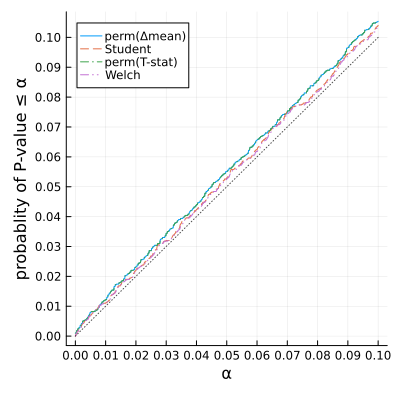

In [15]:
distx, disty = inversegammadist(2, 3), inversegammadist(1, 3)
distx = distx + mean(disty) - mean(distx)
m, n = 100, 100
L = Nshuffles = 5000
@time plot_sim_diff_shuffle(; distx, m, disty, n, L, Nshuffles)

distx = LocationScale{Float64, Continuous, InverseGamma{Float64}}(
μ: -1.8685170918213296
σ: 1.0
ρ: InverseGamma{Float64}(
invd: Gamma{Float64}(α=5.4913561224284395, θ=0.0595793056595373)
θ: 16.784351360427824
)

)

disty = InverseGamma{Float64}(
invd: Gamma{Float64}(α=5.4913561224284395, θ=0.1191586113190746)
θ: 8.392175680213912
)

m = 25
n = 100

Probabilities of P-valune ≤ 5.0%
  perm(Δmean):    18.9%
  Student:        18.9%
  perm(T-stat):    7.8%
  Welch:           7.7%

  5.839519 seconds (11.02 k allocations: 3.902 MiB)


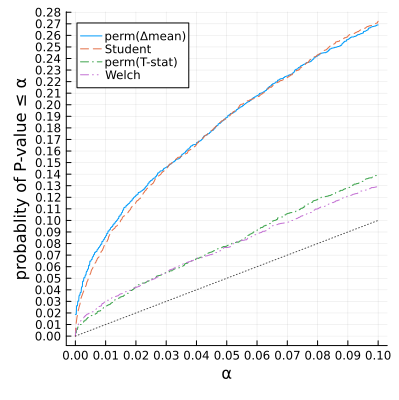

In [16]:
distx, disty = inversegammadist(2, 3), inversegammadist(1, 3)
distx = distx + mean(disty) - mean(distx)
m, n = 25, 100
L = Nshuffles = 5000
@time plot_sim_diff_shuffle(; distx, m, disty, n, L, Nshuffles)

distx = LocationScale{Float64, Continuous, InverseGamma{Float64}}(
μ: -1.8685170918213296
σ: 1.0
ρ: InverseGamma{Float64}(
invd: Gamma{Float64}(α=5.4913561224284395, θ=0.0595793056595373)
θ: 16.784351360427824
)

)

disty = InverseGamma{Float64}(
invd: Gamma{Float64}(α=5.4913561224284395, θ=0.1191586113190746)
θ: 8.392175680213912
)

m = 100
n = 400

Probabilities of P-valune ≤ 5.0%
  perm(Δmean):    17.9%
  Student:        18.2%
  perm(T-stat):    5.8%
  Welch:           5.8%

 20.656568 seconds (11.00 k allocations: 3.904 MiB, 0.06% gc time)


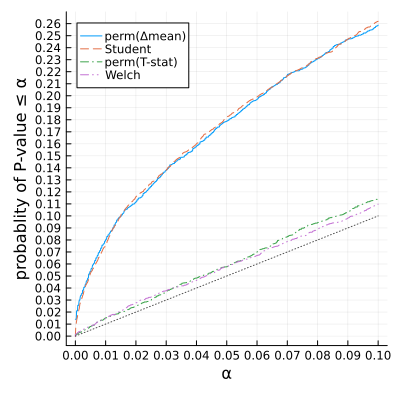

In [17]:
distx, disty = inversegammadist(2, 3), inversegammadist(1, 3)
distx = distx + mean(disty) - mean(distx)
m, n = 100, 400
L = Nshuffles = 5000
@time plot_sim_diff_shuffle(; distx, m, disty, n, L, Nshuffles)

distx = LocationScale{Float64, Continuous, InverseGamma{Float64}}(
μ: -1.8685170918213296
σ: 1.0
ρ: InverseGamma{Float64}(
invd: Gamma{Float64}(α=5.4913561224284395, θ=0.0595793056595373)
θ: 16.784351360427824
)

)

disty = InverseGamma{Float64}(
invd: Gamma{Float64}(α=5.4913561224284395, θ=0.1191586113190746)
θ: 8.392175680213912
)

m = 100
n = 25

Probabilities of P-valune ≤ 5.0%
  perm(Δmean):     0.9%
  Student:         1.0%
  perm(T-stat):    4.2%
  Welch:           4.5%

  5.772701 seconds (7.37 k allocations: 2.841 MiB)


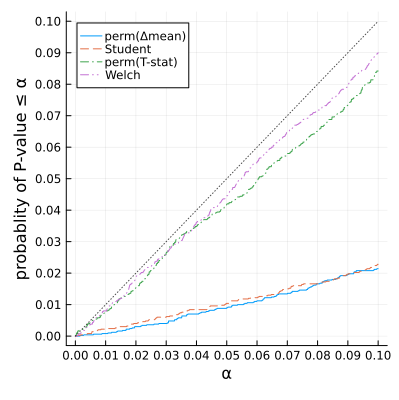

In [18]:
distx, disty = inversegammadist(2, 3), inversegammadist(1, 3)
distx = distx + mean(disty) - mean(distx)
m, n = 100, 25
L = Nshuffles = 5000
@time plot_sim_diff_shuffle(; distx, m, disty, n, L, Nshuffles)